In [1]:
# full data training

In [32]:
import pandas as pd
import numpy as np
import collections
import time

In [33]:
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [34]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [35]:
from sklearn.preprocessing import StandardScaler

amount_after_scaling = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

data.drop(['Time', 'Amount'], axis=1, inplace=True)
data.insert(0, 'Amount_after_scaling', amount_after_scaling)

In [36]:
from sklearn.model_selection import train_test_split

X = data.drop('Class', axis=1)
y = data['Class']
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X,y,test_size=0.20,random_state=42)
y_data_test_non_fraud_num = y_data_test.value_counts()[0]
y_data_test_fraud_num = y_data_test.value_counts()[1]

print('Broj transakcija u trening skupu: ' + str(len(y_data_train)))
print('Broj transakcija u testnom skupu: ' + str(len(y_data_test)))
print('Ukupan broj transakcija: ' + str(len(y_data_train) + len(y_data_test)))

Broj transakcija u trening skupu: 227845
Broj transakcija u testnom skupu: 56962
Ukupan broj transakcija: 284807


In [37]:
from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

In [38]:
%run functions.ipynb

## Logistička regresija

In [27]:

log_reg_t_start = time.time()
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_data_train, y_data_train)

log_reg_training_score = cross_val_score(log_reg, X_data_train, y_data_train, cv=rskf)
log_reg_t_end = time.time()

print('Rezultat treniranja za logističku regresiju: ' 
     + str(round(log_reg_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za logističku regresiju: ' + str(round(log_reg_t_end - log_reg_t_start, 2)) + ' seconds.')

Rezultat treniranja za logističku regresiju: 99.92%
Duljina treninga za logističku regresiju: 50.2 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 86.15%
	Recall score: 57.14%
	F1 score: 68.71000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.57      0.69        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


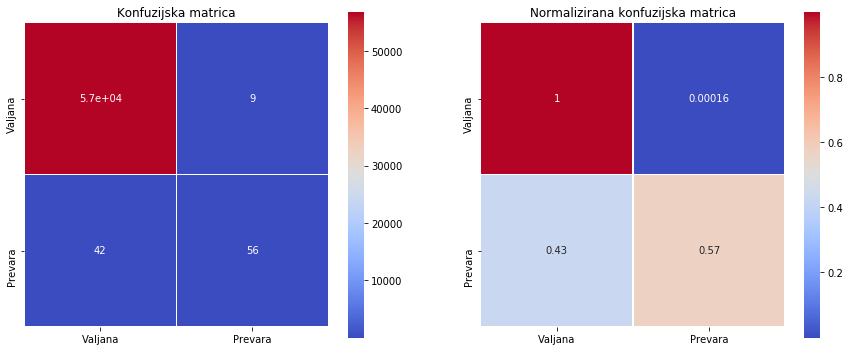

----------------------------------------------------------------------------------------------------


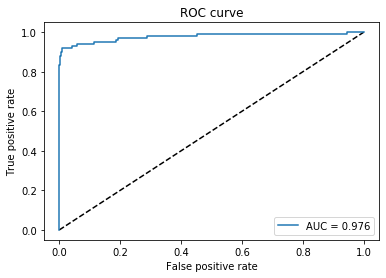

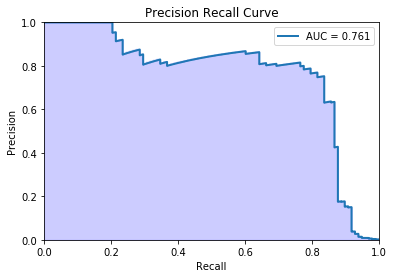

In [28]:
pred_log_reg = log_reg.predict(X_data_test)
score_log_reg = log_reg.decision_function(X_data_test)
print_everything(y_data_test, pred_log_reg, y_data_test_non_fraud_num, y_data_test_fraud_num, score_log_reg, True)


Vidimo da smo korištenjem  logističke regresije dobili solidne rezultate. Najveća mana treninga na cijelom skupu podataka je overfitting. Kao što vidimo preciznost (86.15%) i f1-mjera (68.71%) su prilično visoki, dok je osjetljivost samo 57.14%. Iz matrice konfuzije vidimo da model jako dobro klasificira valjane transakcije (samo 9 pogrešno klasificiranih od ukupno ~57 000). Problem je kod klasifikacije prevara. Model je je od 98 prevara ispravno klasificirao njih samo 56, što znači da će 42 ljudi ,koji su počinili neku vrstu kartične pronevjere, ostati neuhvaćeni. Napomenimo još da je prednost korištenja logističke regresije vrijeme treninga: (u ovom slučaju samo 50.2 sekunde).

## Stabla odluke

In [30]:

dt_t_start = time.time()
dt = DecisionTreeClassifier()
dt.fit(X_data_train, y_data_train)

dt_training_score = cross_val_score(dt, X_data_train, y_data_train, cv=rskf)
dt_t_end = time.time()

print('Rezultat treniranja za stabla odluke: ' 
     + str(round(dt_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za stabla odluke: ' + str(round(dt_t_end - dt_t_start, 2)) + ' seconds.')

Rezultat treniranja za stabla odluke: 99.91%
Duljina treninga za stabla odluke: 407.84 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 70.91%
	Recall score: 79.59%
	F1 score: 75.0%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.80      0.75        98

    accuracy                           1.00     56962
   macro avg       0.85      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


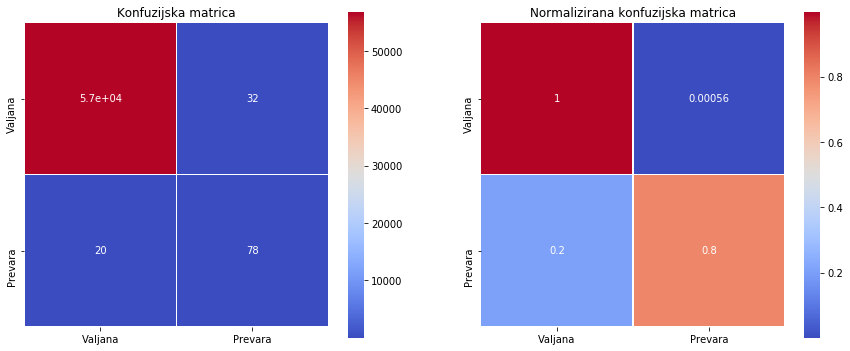

----------------------------------------------------------------------------------------------------


In [31]:
pred_dt = dt.predict(X_data_test)
print_everything(y_data_test, pred_dt, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)


Korištenjem stabala odluke smo dobili poprilično drugačije rezultate (u odnosu na logističku regresiju). Preciznost (70.91%) je u ovom slučaju nešto manja, no zato su i f1-mjera (75.0%) i osjetljivost (79.59%) viši. Iz matrice konfuzije vidimo da je pogrešno klasificirano 32 (kod logističke regresije je bilo 9) valjane transakcije (što je i dalje malo obzirom da ih je ukupno ~57000). No, ovaj model je zato ispravno klasificirao čak 78 prevara (22 više od logističke regresije). To znači da bi policija korištenjem ovog modela uhvatila 23% prevaranata više. Zato možemo reći da je ovaj model dosta bolji od prošlog. Mana korištenja stabala odluke u odnosu na logističku regresiju je vrijeme potrebno za treniranje modela. Dok je za logističku regresiju bilo potrebno 50.7 sekundi, ovdje je trajalo čak 407.84 sekundi, što je čak 8 puta duže).

## Bagging klasifikator

In [9]:

bag_t_start = time.time()
bag = BaggingClassifier()
bag.fit(X_data_train, y_data_train)

bag_training_score = cross_val_score(bag, X_data_train, y_data_train, cv=rskf)
bag_t_end = time.time()

print('Rezultat treniranja za bagging klasifikator na stablima odluke: ' 
     + str(round(bag_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za bagging na stablima odluke: ' + str(round(bag_t_end - bag_t_start, 2)) + ' seconds.')

Rezultat treniranja za bagging klasifikator na stablima odluke: 99.95%
Duljina treninga za bagging na stablima odluke: 2263.53 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 98.68%
	Recall score: 76.53%
	F1 score: 86.21%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


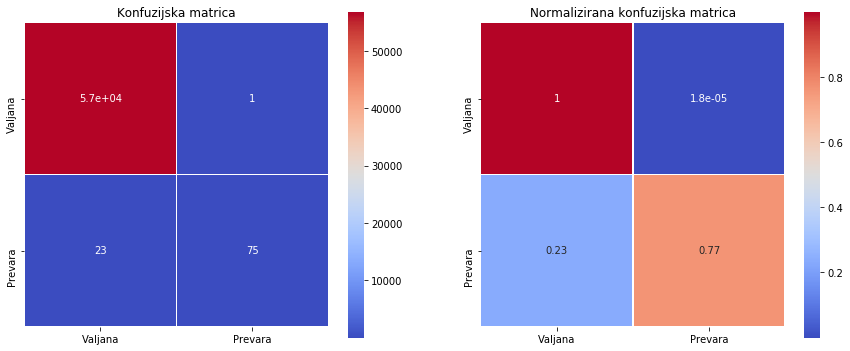

----------------------------------------------------------------------------------------------------


In [10]:
pred_bag = bag.predict(X_data_test)
print_everything(y_data_test, pred_bag, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Bagging klasifikator zasad ima najbolje rezultate, ali mu je i treniranje trajalo daleko najduže (2263.53 sekunde = ~38min). Ovaj model ima dosad najveću preciznost (98.68%) i f1-mjeru (86.21%), dok mu je osjetljivost (76.53%) tek nešto slabija od prethodnog modela (79.59%). Iz matrice konfuzije vidimo da je ovaj model pogrešno klasificirao samo 1 valjanu transakciju, dok je pogrešno klasificirao 23 prevare (3 više od prethodnog modela). S toga možemo reći da ovaj model nije bolji od prethodnog. Odnosno, za prethodni model policija mora provjeriti 32 pogrešno klasificirane prevare i utvrditi da su valjane transakcije, dok bi za ovaj model uhapsili 3 pravih prevaranata manje.

## Slučajne šume

In [12]:

rf_t_start = time.time()
rf = RandomForestClassifier()
rf.fit(X_data_train, y_data_train)

rf_training_score = cross_val_score(rf, X_data_train, y_data_train, cv=rskf)
rf_t_end = time.time()

print('Rezultat treniranja za slučajne šume: ' 
     + str(round(rf_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za slučajne šume: ' + str(round(rf_t_end - rf_t_start, 2)) + ' seconds.')

Rezultat treniranja za slučajne šume: 99.95%
Duljina treninga za slučajne šume: 9144.55 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 98.68%
	Recall score: 76.53%
	F1 score: 86.21%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


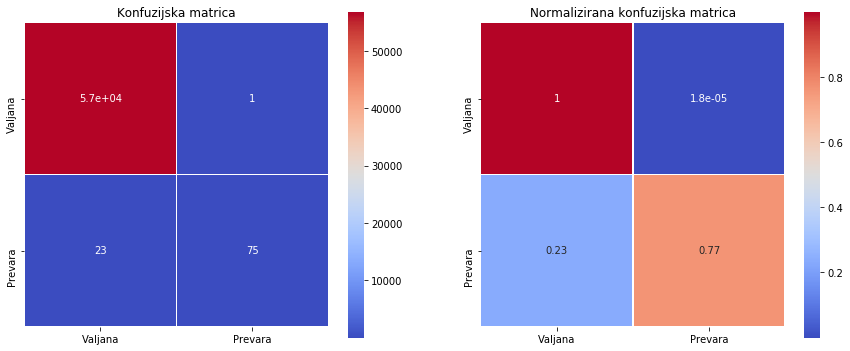

----------------------------------------------------------------------------------------------------


In [13]:
pred_rf = rf.predict(X_data_test)
print_everything(y_data_test, pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći slučajne šume dobili smo po svim komponentama iste rezultate kao bagging klasifikatorom. Odnosno preciznost je 98.68%, osjetljivost 76.53%, a f1-mjera 86.21%. Ovaj model je također (kao i bagging klasifikator) pogrešno klasificirao 1 valjanu transakciju, te  pogrešno klasificirao 23 prevare. Mana ovog modela je što je bio još sporiji od prethodnog (trening je trajao čak 9144.55s ~2.5h).

## Metoda najbližih susjeda

In [9]:

knn_t_start = time.time()
knn = KNeighborsClassifier()
knn.fit(X_data_train, y_data_train)

knn_training_score = cross_val_score(knn, X_data_train, y_data_train, cv=rskf)
knn_t_end = time.time()

print('Rezultat treniranja za metodu najbližih susjeda: ' 
     + str(round(knn_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za metodu najbližih susjeda: ' + str(round(knn_t_end - knn_t_start, 2)) + ' seconds.')

Rezultat treniranja za metodu najbližih susjeda: 99.94%
Duljina treninga za metodu najbližih susjeda: 2947.68 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 93.83%
	Recall score: 77.55%
	F1 score: 84.92%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


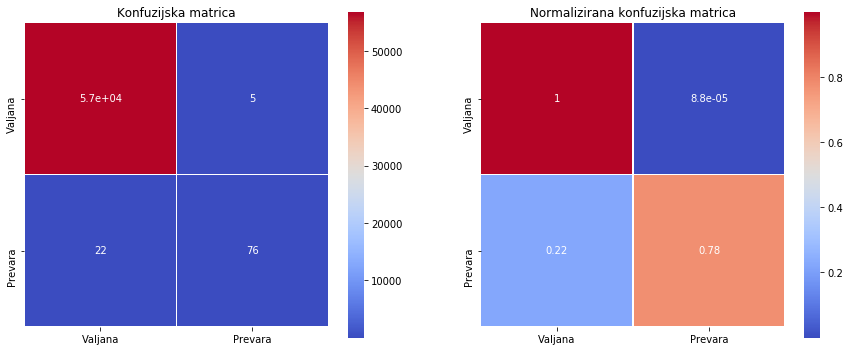

----------------------------------------------------------------------------------------------------


In [10]:
pred_knn = knn.predict(X_data_test)
print_everything(y_data_test, pred_knn, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Korištenjem metode najbližih susjeda dobili smo vrlo slične rezultate kao i u prethodna 2 modela. Ovaj put su preciznost (93.83%) i f1-mjera(84.92%) malo niži, ali je osjetljivost (77.55%) viša. Iz matrice konfuzije vidimo da je 5 (4 više nego kod prethodnog modela) valjanih transakcija klasificirano kao prevare te su 22 (jedna manje nego kod prethodnog modela) prevare klasificirane kao valjane transakcije. Vrijeme potrebno za treniranje modela je također prilično dugo (29487.68sec = ~49min), no i dalje dosta kraće nego kod slučajnih šuma.

## Metoda potpornih vektora

In [16]:

svc_t_start = time.time()
svc = SVC()
svc.fit(X_data_train, y_data_train)

svc_training_score = cross_val_score(svc, X_data_train, y_data_train, cv=rskf)
svc_t_end = time.time()

print('Rezultat treniranja za metodu potpornih vektora: ' 
     + str(round(svc_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za metodu potpornih vektora: ' + str(round(svc_t_end - svc_t_start, 2)) + ' seconds.')

Rezultat treniranja za metodu potpornih vektora: 99.94%
Duljina treninga za metodu potpornih vektora: 9105.19 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 96.83%
	Recall score: 62.239999999999995%
	F1 score: 75.78%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.62      0.76        98

    accuracy                           1.00     56962
   macro avg       0.98      0.81      0.88     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


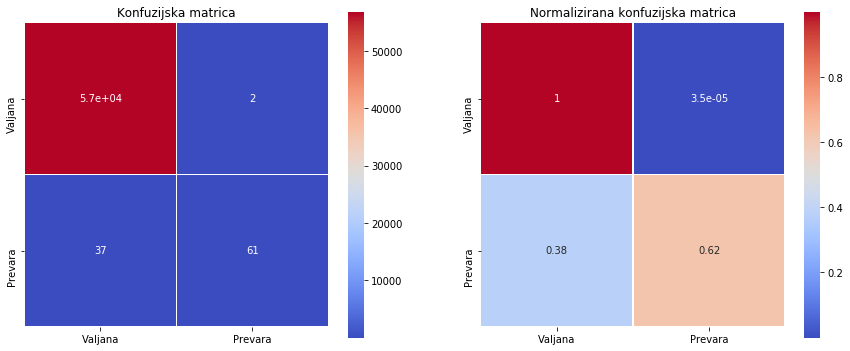

----------------------------------------------------------------------------------------------------


In [17]:
pred_svc = svc.predict(X_data_test)
print_everything(y_data_test, pred_svc, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Za razliku od prethodnih par modela, metoda potpornih vektora je postigla nešto slabije rezultate. Svi prethodni klasifikatori (osim logističke regresije) su postigli značajno bolje rezultate od ovog algoritma. Usporedimo li ovaj model sa slučajnim šumama primjerice, vidjet ćemo da je metoda potpornih vektora imala i manju preciznost (96.83%), i manju osjetljivost (62.24%), i manju f1-mjeru (75.78%). Iz konfuzijske matrice vidimo da je broj valjanih transakcija klasificiranih kao prevare prilično nizak (samo 2), ali je zato broj pogrešno klasificiranih prevara jako visok (37 od ukupno 98, što je ~38%). Osim što su rezultati loši i treniranje je bilo jako sporo (9105.19s = ~2.5h). 

## Boosting

Boosting algoritmi koje koristimo:
<ol>
    <li>XGB (eXtreme Gradient Boosting)</li>
    <li>LGBM (Light Gradient Boosting Method)</li>
    <li>CatBoost (CATegorical Boosting)</li>
    <li>AdaBoost (ADAptive Boosting)</li>
</ol>

### XGB

In [19]:
print("XGB (eXtreme Gradient Boosting)")
xgb_t_start = time.time()
xgb = XGBClassifier()
xgb.fit(X_data_train, y_data_train)

xgb_training_score = cross_val_score(xgb, X_data_train, y_data_train, cv=rskf)
xgb_t_end = time.time()

print("Rezultat treniranja za XGB (extreme gradient boosting): " + 
       str(round(xgb_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za XGB: ' + str(round(xgb_t_end - xgb_t_start, 2)) + ' seconds.')

XGB (eXtreme Gradient Boosting)
Rezultat treniranja za XGB (extreme gradient boosting): 99.95%
Duljina treninga za XGB: 963.02 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 93.02%
	Recall score: 81.63%
	F1 score: 86.96000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


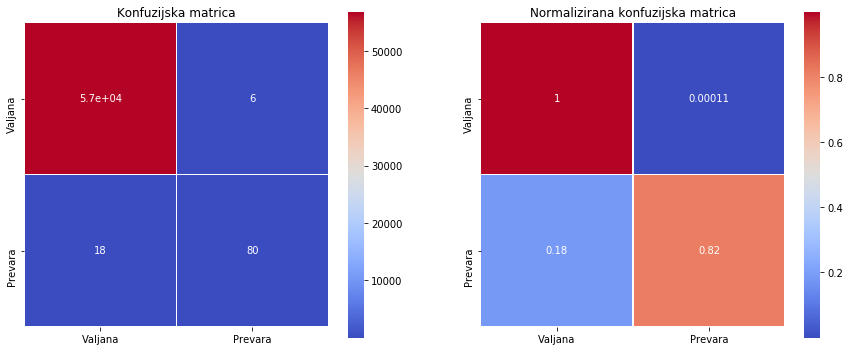

----------------------------------------------------------------------------------------------------


In [20]:
pred_xgb = xgb.predict(X_data_test)
print_everything(y_data_test, pred_xgb, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Prvi boosting algoritam koji promatramo je XGB (eXtreme Gradient Boosting) i on je odmah pokazao impresivne rezulate. Vidimo da je osjetljivost najviša dosad (81.63%), dok su i preciznost (93.02%) i f1-mjera (86.96% - također najviše dosad) također vrlo visoke. Iz matrice konfuzije vidimo da je model ispravno klasificirao 80 prevara (dosad je najviše bilo 78), dok je pogrešno klasificirao samo 6 valjanih transakcija. Možemo reći da ovaj model zasad ima najbolje rezultate. Uz sve to čak je i trening bio brz (samo 963.02s = ~16min).

### LGBM

In [39]:
print("LGBM (Light Gradient Boosting Method)")
lgbm_t_start = time.time()
lgbm = LGBMClassifier()
lgbm.fit(X_data_train, y_data_train)

lgbm_training_score = cross_val_score(lgbm, X_data_train, y_data_train, cv=rskf)
lgbm_t_end = time.time()

print("Rezultat treniranja za LGBM (light gradient boosting method): " + 
       str(round(lgbm_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za LGBM: ' + str(round(lgbm_t_end - lgbm_t_start, 2)) + ' seconds.')

LGBM (Light Gradient Boosting Method)
Rezultat treniranja za LGBM (light gradient boosting method): 99.61%
Duljina treninga za LGBM: 35.71 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 40.82%
	Recall score: 61.22%
	F1 score: 48.980000000000004%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.41      0.61      0.49        98

    accuracy                           1.00     56962
   macro avg       0.70      0.81      0.74     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


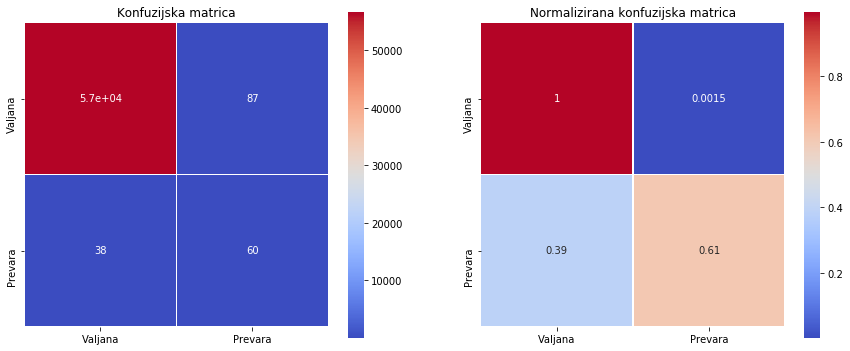

----------------------------------------------------------------------------------------------------


In [40]:
pred_lgbm = lgbm.predict(X_data_test)
print_everything(y_data_test, pred_lgbm, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Sljedeći boosting algoritam koji koristimo je LGBM. Za razliku od XGB-a, ovaj algoritam je dao prilično loše rezultate. Preciznost je samo 40.82%, dok je f1-mjera 48.98%. Osjetljivost je nešto viša (61.22%) no također poprilično niža od prethodnih modela. Iz matrice konfuzije vidimo da je ovaj model ispravno klasificirao svega 60 prevara te čak 87 pogrešno klasificiranih valjanih transakcija. Ako ništa, treniranje je bilo najbrže dosad (svega 35.71s).

### CatBoost

In [23]:
print("CatBoost (Categorical Boosting)")
cat_t_start = time.time()
cat = CatBoostClassifier(silent=True)
cat.fit(X_data_train, y_data_train)

cat_training_score = cross_val_score(cat, X_data_train, y_data_train, cv=rskf)
cat_t_end = time.time()

print("Rezultat treniranja za CatBoost (categorical boosting): " + 
       str(round(cat_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za CatBoost: ' + str(round(cat_t_end - cat_t_start, 2)) + ' seconds.')

CatBoost (Categorical Boosting)
Rezultat treniranja za CatBoost (categorical boosting): 99.96000000000001%
Duljina treninga za CatBoost: 1066.02 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 97.5%
	Recall score: 79.59%
	F1 score: 87.64%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.80      0.88        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


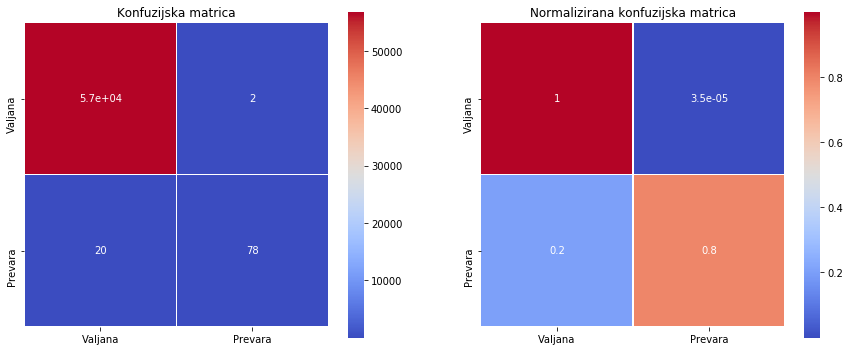

----------------------------------------------------------------------------------------------------


In [24]:
pred_cat = cat.predict(X_data_test)
print_everything(y_data_test, pred_cat, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći CatBoost dobili smo slične rezultate kao i kod prethodna 2. Ovaj put imamo nešto veću preciznost (97.5%) i f1-mjeru (87.64%), ali i nešto manju osjetjivost (79.59%). Iz konfuzijske matrice vidimo da je ovaj model pogrešno klasificirao samo 2 valjane transakcije (XGB je 6), ali je zato ispravno klasificirao 'samo' 78 prevara (XGB je 80). Možemo reći da je ovaj model ipak nešto lošiji jer su nam važnije ispravno klasificirane prevare (tako dobivamo koga treba kazniti) nego pogrešno klasificirane valjane transakcije (ako si pogrešno optužen za prevaru lako je opovrgnuti).  

### AdaBoost

In [41]:
print("AdaBoost (Adaptive Boosting)")
ada_t_start = time.time()
ada = AdaBoostClassifier()
ada.fit(X_data_train, y_data_train)

ada_training_score = cross_val_score(ada, X_data_train, y_data_train, cv=rskf)
ada_t_end = time.time()

print("Rezultat treniranja za AdaBoost (adaptive boosting): " + 
       str(round(ada_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za AdaBoost: ' + str(round(ada_t_end - ada_t_start, 2)) + ' seconds.')

AdaBoost (Adaptive Boosting)
Rezultat treniranja za AdaBoost (adaptive boosting): 99.92%
Duljina treninga za AdaBoost: 869.98 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 83.72%
	Recall score: 73.47%
	F1 score: 78.25999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.73      0.78        98

    accuracy                           1.00     56962
   macro avg       0.92      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


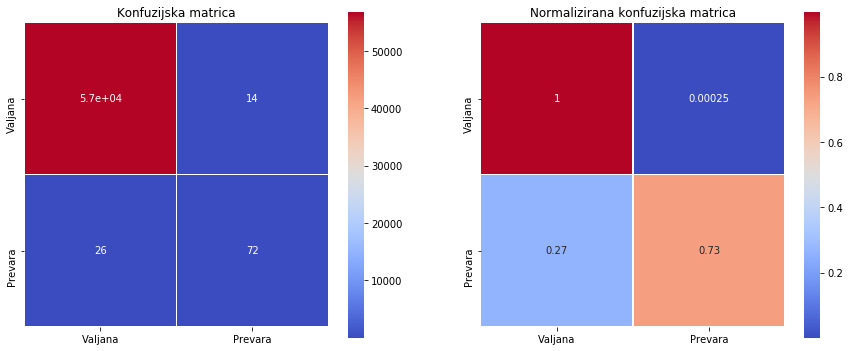

----------------------------------------------------------------------------------------------------


In [42]:
pred_ada = ada.predict(X_data_test)
print_everything(y_data_test, pred_ada, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Posljednji boosting algoritam koji koristimo je AdaBoost. AdaBoostom također nismo dobili impresivne rezultate (iako je i dalje dosta bolje od LGBM-a). Kod AdaBoosta je preciznost 83.72%, osjetljivost 73.47% te f1-mjera 78.26%. Iz matrice konfuzije vidimo da je 14 pogrešno klasificiranih valjanih transakcija, te 26 pogrešno klasificiranih prevara (u oba slučaja slabije i od CatBoosta i od XGB-a). 